AAPL, MSTF, TSLA, GG
1 năm và 10 năm


# Model

In [1]:
!pip install pmdarima

# 1

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM,Dropout
from sklearn.metrics import accuracy_score
from tensorflow.keras import datasets, layers,models
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, Activation,SimpleRNN
import tensorflow.keras as keras
from sklearn.neural_network import MLPRegressor
from sklearn import metrics

from pmdarima.arima import auto_arima
import pmdarima as pm
import statsmodels.api as sm

from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import math

import plotly.graph_objects as go
from datetime import datetime
tf.random.set_seed(7)

class stock_predict_DL:

    def __init__(self,comp_df):
        # reseved method in python classes (Constructor)
        # We are taking only the Open prices for predicting
        data = comp_df.filter(['Close'])
        dataset = data.values

        self.dataset_ = comp_df['Close']
        self.train_data, self.test_data = comp_df[:int(len(comp_df)*0.9)], comp_df[int(len(comp_df)*0.9):]

        # We take 90% of the data for training and 10% for testing
        training_data_len = int(np.ceil( len(dataset) * 0.90 ))
        # We are scaling the open prices to the range(0,1)
        self.scaler = MinMaxScaler(feature_range=(0,1))
        scaled_data = self.scaler.fit_transform(dataset)
        # Taking the first 90% of the dataset for training
        train_data = scaled_data[0:int(training_data_len), :]
        # Split the data into self.X_train and self.y_train data sets
        self.X_train = []
        self.y_train = []

        # We are taking predicting the open price of a given day based on the trend in the previous 60 days
        for i in range(60, len(train_data)):
            self.X_train.append(train_data[i-60:i, 0])
            self.y_train.append(train_data[i, 0])

        # Convert the self.X_train and self.y_train to numpy arrays
        self.X_train, self.y_train = np.array(self.X_train), np.array(self.y_train)

        # Create the testing data set
        # Create a new array containing scaled values from index 1543 to 2002
        test_data = scaled_data[training_data_len - 60: , :]
        # Create the data sets self.X_test and self.y_test
        self.X_test = []
        # Rmaining 10% of the data needs to be given for testing
        self.y_test = dataset[training_data_len:, :]
        for i in range(60, len(test_data)):
            self.X_test.append(test_data[i-60:i, 0])

        # Convert the data to a numpy array
        self.X_test = np.array(self.X_test)
        test_dates = comp_df['Date'].values
        self.testd = test_dates[training_data_len:] # stores the test dates
        # List to store the R2 scores of all the models to get the best model at the end
        self.model_score = []
        # List to store the RMSE scores of all the models to get the best model at the end
        self.model_score_rmse = []
        # List to store the RMSE scores of all the models to get the best model at the end
        self.model_score_mape = []

    def LSTM_model(self):

        print("Long Short-Term Memory (LSTM)")
        # Reshape the data
        Xtrain = np.reshape(self.X_train, (self.X_train.shape[0], self.X_train.shape[1], 1))
        # Reshape the data
        Xtest = np.reshape(self.X_test, (self.X_test.shape[0], self.X_test.shape[1], 1 ))

        # Build the LSTM model
        model = Sequential()
        model.add(LSTM(128, return_sequences=True,
                       input_shape= (Xtrain.shape[1], 1)))
        model.add(Dropout(0.2))
        model.add(LSTM(64, return_sequences=False))
        model.add(Dropout(0.2))
        model.add(Dense(32))
        model.add(Dropout(0.2))
        model.add(Dense(1))
        # We are adding dropout to reduce overfitting
        # Compile the model
        model.compile(optimizer='adam', loss='mean_squared_error')
        # Train the model
        model.fit(Xtrain, self.y_train, batch_size=32, epochs= 2)

         # Get the models predicted price values
        predictions = model.predict(Xtest)
        # We need to inverse transform the scaled data to compare it with our unscaled y_test data
        predictions = self.scaler.inverse_transform(predictions)

        x = predictions
        y = self.y_test
        rmse = math.sqrt(mean_squared_error(y, x))
        print('RMSE: '+str(rmse))
        mape = np.mean(np.abs(x - y)/np.abs(y))
        print('MAPE: '+str(mape))

        self.model_score_mape.append(["LSTM ", mape])
        self.model_score_rmse.append(["LSTM ", rmse])

          # Plot the data - ve du lieu

        valid = self.test_data[1:]
        valid['Predictions'] = predictions
        x = valid['Predictions']
        y = valid['Close']

        plt.plot(x)
        plt.plot(y)
        plt.legend(["Predicted","Observed"])
        plt.xticks(rotation=45)
        plt.xlabel('Date',fontsize=18)
        plt.ylabel('Price',fontsize=18)
        plt.title("LSTM")

    def LSTM_model_2(self, epochs):

        print("Long Short-Term Memory (LSTM)")
        # Reshape the data
        Xtrain = np.reshape(self.X_train, (self.X_train.shape[0], self.X_train.shape[1], 1))
        # Reshape the data
        Xtest = np.reshape(self.X_test, (self.X_test.shape[0], self.X_test.shape[1], 1 ))

        # Build the LSTM model
        model = Sequential()
        model.add(LSTM(128, return_sequences=True,
                       input_shape= (Xtrain.shape[1], 1)))
        model.add(Dropout(0.2))
        model.add(LSTM(64, return_sequences=False))
        model.add(Dropout(0.2))
        model.add(Dense(32))
        model.add(Dropout(0.2))
        model.add(Dense(1))
        # We are adding dropout to reduce overfitting
        # Compile the model
        model.compile(optimizer='adam', loss='mean_squared_error')
        # Train the model
        model.fit(Xtrain, self.y_train, batch_size=32, epochs= epochs)

         # Get the models predicted price values
        predictions = model.predict(Xtest)
        # We need to inverse transform the scaled data to compare it with our unscaled y_test data
        predictions = self.scaler.inverse_transform(predictions)

        x = predictions
        y = self.y_test
        rmse = math.sqrt(mean_squared_error(y, x))
        print('RMSE: '+str(rmse))
        mape = np.mean(np.abs(x - y)/np.abs(y))
        print('MAPE: '+str(mape))

        self.model_score_mape.append([f"LSTM {epochs} epochs", mape])
        self.model_score_rmse.append([f"LSTM {epochs} epochs", rmse])

          # Plot the data - ve du lieu

        valid = self.test_data[1:]
        valid['Predictions'] = predictions
        x = valid['Predictions']
        y = valid['Close']

        plt.plot(x)
        plt.plot(y)
        plt.legend(["Predicted","Observed"])
        plt.xticks(rotation=45)
        plt.xlabel('Date',fontsize=18)
        plt.ylabel('Price',fontsize=18)
        plt.title("LSTM")

    def rnn_model(self):

        print("Recurrent neural network (RNN)")
        # Reshape the data
        Xtrain = np.reshape(self.X_train, (self.X_train.shape[0], self.X_train.shape[1], 1))
        # Reshape the data
        Xtest = np.reshape(self.X_test, (self.X_test.shape[0], self.X_test.shape[1], 1 ))
        # model = Sequential()

        # model.add(SimpleRNN(units=4, input_shape=(Xtrain.shape[1], Xtrain.shape[2])))
        # model.add(Dense(1))
        # model.compile(loss='mean_squared_error', optimizer='adam')
        # model.fit(Xtrain, self.y_train, epochs=10, batch_size=1)

        # model.add(SimpleRNN(units=4, input_shape=(Xtrain.shape[1], Xtrain.shape[2])))
        model = keras.models.Sequential([
                keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None,1]),
                keras.layers.SimpleRNN(20, return_sequences=True),
                keras.layers.SimpleRNN(20, return_sequences=True),
                keras.layers.SimpleRNN(1)])
        model.add(Dense(1))
        model.compile(loss='mean_squared_error', optimizer='adam')
        model.fit(Xtrain, self.y_train, epochs=1, batch_size=1)

        # initializing the RNN
        # model = Sequential()
        # # adding RNN layers and dropout regularization
        # model.add(SimpleRNN(units = 50,
        #                         activation = "tanh",
        #                         return_sequences = True,
        #                         input_shape = (self.X_train.shape[1],1)))
        # model.add(Dropout(0.2))
        # model.add(SimpleRNN(units = 50,
        #                         activation = "tanh",
        #                         return_sequences = True))
        # model.add(SimpleRNN(units = 50,
        #                         activation = "tanh",
        #                         return_sequences = True))
        # model.add( SimpleRNN(units = 50))
        # model = Sequential([keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None,
        #                     1]),
        #                     keras.layers.SimpleRNN(20, return_sequences=True),
        #                     keras.layers.SimpleRNN(20, return_sequences=True),
        #                     keras.layers.SimpleRNN(1)
        #                     ])
        # adding the output layer
        # model.add(Dense(units = 1,activation='sigmoid'))
        # epochs = 10
        # learning_rate = 0.01
        # decay_rate = learning_rate / epochs
        # # compiling RNN
        # model.compile(loss='mean_squared_error',
        #                   optimizer= tf.keras.optimizers.Adam(1e-4),
        #                   metrics = ['RootMeanSquaredError'])
        # # fitting the model
        # model.fit(self.X_train, self.y_train, epochs = epochs, batch_size = 50)

        # predicting the opening prices
        prediction = model.predict(Xtest)
        y_pred = self.scaler.inverse_transform(prediction)

        x = y_pred
        y = self.y_test

        rmse = math.sqrt(mean_squared_error(y, x))
        print('RMSE: '+str(rmse))
        mape = np.mean(np.abs(x - y)/np.abs(y))
        print('MAPE: '+str(mape))

        self.model_score_mape.append(["RNN", mape])
        self.model_score_rmse.append(["RNN", rmse])

       # Plot the data - ve du lieu

        valid = self.test_data[1:]
        valid['Predictions'] = y_pred
        x = valid['Predictions']
        y = valid['Close']

        plt.plot(x)
        plt.plot(y)
        plt.legend(["Predicted","Observed"])
        plt.xticks(rotation=45)
        plt.xlabel('Date',fontsize=18)
        plt.ylabel('Price',fontsize=18)
        plt.title("RNN")

    def arima_model(self):
        print("Autoregressive Integrated Moving Average(ARIMA)")

        # Get data
        # split data 9:1
        data = self.dataset_
        train_data, test_data = data[3:int(len(data)*0.9)], data[int(len(data)*0.9):]

        # find parameters
        arima_model = pm.auto_arima(data, start_p=0, start_q=0,
                         test='adf',
                         max_p=3, max_q=3, m=1,
                         start_P=0, seasonal=False,
                         d=None, D=0, trace=True,
                         error_action='ignore',
                         suppress_warnings=True,
                         stepwise=True)

        arima_model.summary()
        model = sm.tsa.arima.ARIMA(data, order=arima_model.order)
        model_fit = model.fit()

        pred_start = test_data.index[0]
        pred_end = test_data.index[-1]



        # predicting the opening prices
        y_pred = model_fit.predict(start= pred_start , end = pred_end)

        x = y_pred
        y = test_data

        rmse = math.sqrt(mean_squared_error(y, x))
        print('RMSE: '+str(rmse))
        mape = np.mean(np.abs(x - y)/np.abs(y))
        print('MAPE: '+str(mape))

        self.model_score_mape.append(["ARIMA", mape])
        self.model_score_rmse.append(["ARIMA", rmse])

        plt.plot(x[1:])
        plt.plot(y)
        plt.legend(["Predicted","Observed"])
        plt.xticks(rotation=45)
        plt.xlabel('Date',fontsize=18)
        plt.ylabel('Price',fontsize=18)
        plt.title("ARIMA")

    def best_model(self):
        #function to find the best model based on the accuracies of the models trained

        print("RMSE")
        print(self.model_score_rmse)
        Dict = {item[0]: item[1:][0] for item in self.model_score_rmse}
        keys = list(Dict.keys()) # creating a list of Dict keys
        vals = list(Dict.values()) # creating a list of Dict values
        print("The best model is ",keys[vals.index(min(vals))]) # getting the model with the highest accuracy
        print("Accuracy of ",keys[vals.index(min(vals))],'is',min(vals)) #getting the accuracy of the best model

        print("MAPE")
        print(self.model_score_mape)
        Dict = {item[0]: item[1:][0] for item in self.model_score_mape}
        keys = list(Dict.keys()) # creating a list of Dict keys
        vals = list(Dict.values()) # creating a list of Dict values
        print("The best model is ",keys[vals.index(min(vals))]) # getting the model with the highest accuracy
        print("Accuracy of ",keys[vals.index(min(vals))],'is',min(vals)) #getting the accuracy of the best model




# Begin

# AAPL

## 2010 - 2023

In [15]:
import yfinance as yf
import pandas as pd

ticker = yf.Ticker("AAPL")
aapl = ticker.history(start="2010-01-01", end="2023-12-31")

# convert index datetime to date
aapl.index = aapl.index.map(lambda x: x.date())

# Convert index column to date column
aapl.index = pd.to_datetime(aapl.index)
aapl.drop(['Dividends', 'Stock Splits'], axis=1, inplace=True)
aapl['Date'] = aapl.index
aapl.shape

(3522, 6)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


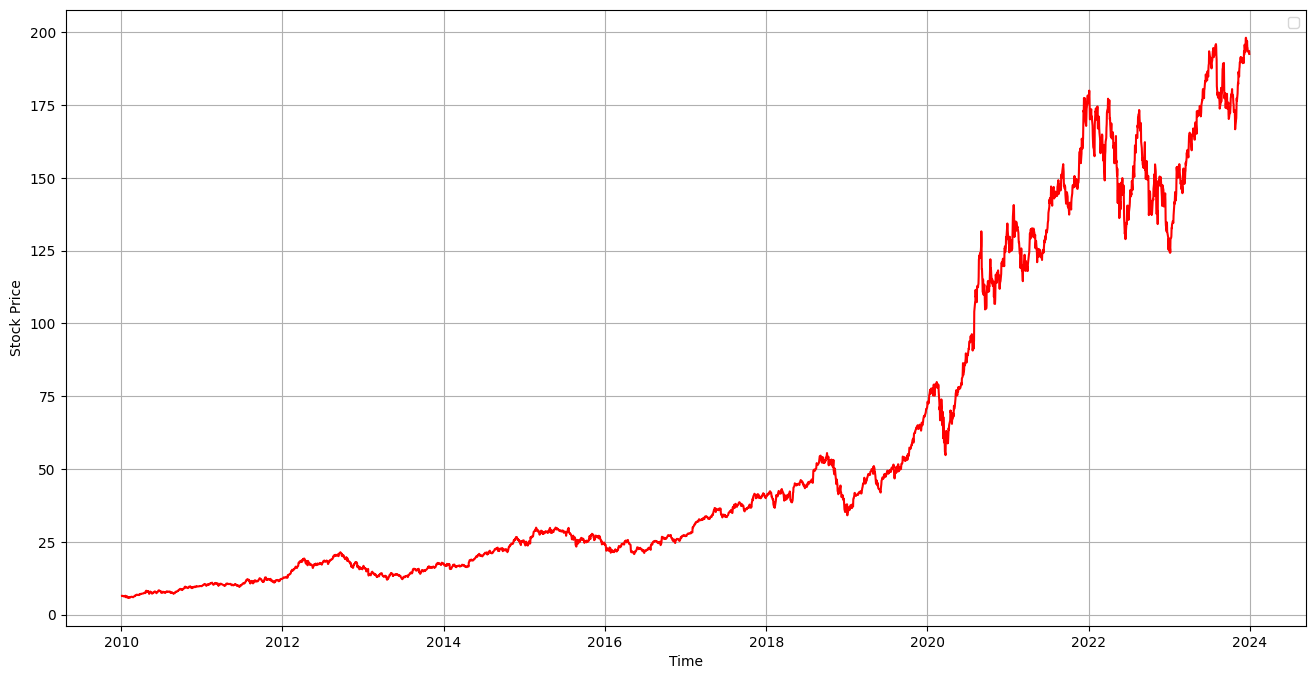

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16,8))
plt.plot(aapl.index, aapl['Close'], color = 'red')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)

plt.show()

In [16]:
train_data, test_data = aapl[3:int(len(aapl)*0.9)], aapl[int(len(aapl)*0.9):]

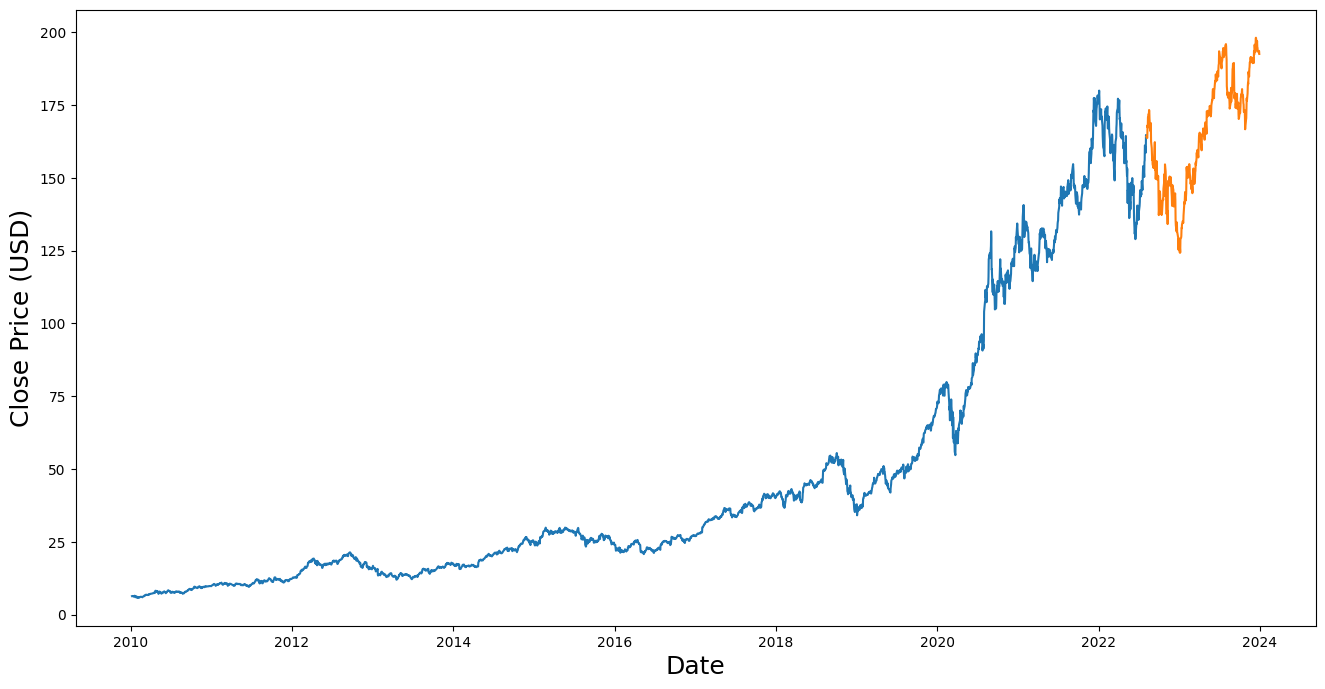

In [17]:
train_data, test_data = aapl[3:int(len(aapl)*0.9)], aapl[int(len(aapl)*0.9):]

plt.figure(figsize=(16,8))
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price (USD)', fontsize=18)
plt.plot(train_data['Close'])
plt.plot(test_data['Close'])
plt.show()

In [ ]:
company_stock = stock_predict_DL(aapl)


### ARIMA

Autoregressive Integrated Moving Average(ARIMA)
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=12607.029, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=12604.238, Time=0.21 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=12603.987, Time=0.48 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=12609.709, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=12603.919, Time=1.91 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=12605.528, Time=2.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=12605.556, Time=1.90 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=12603.836, Time=1.17 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=12605.365, Time=1.53 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=12596.615, Time=3.70 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=9.74 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=12607.644, Time=2.47 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=12599.820, Time=1.27 sec

Best model:  ARIMA(1,1,3)(0,0,0)[0] interce

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


RMSE: 2.567319880920929
MAPE: 0.01197033499466877


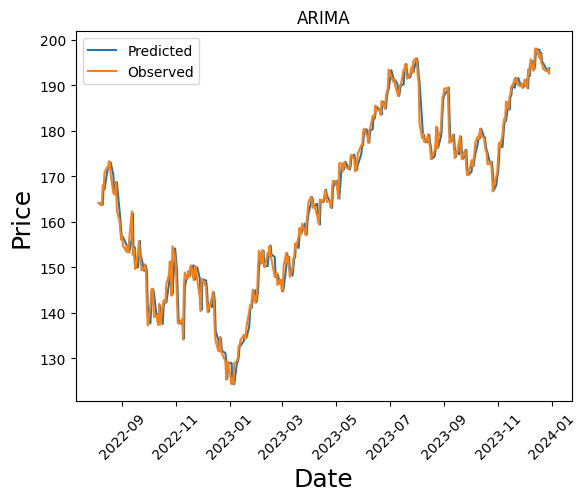

In [ ]:
company_stock.arima_model()

### LSTM

Long Short-Term Memory (LSTM)
Epoch 1/2
98/98 [==============================] - 15s 114ms/step - loss: 0.0057
Epoch 2/2
11/11 [==============================] - 2s 67ms/step
RMSE: 5.46069882162589
MAPE: 0.027253900607681084


<ipython-input-28-ab32fcf984a7>:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


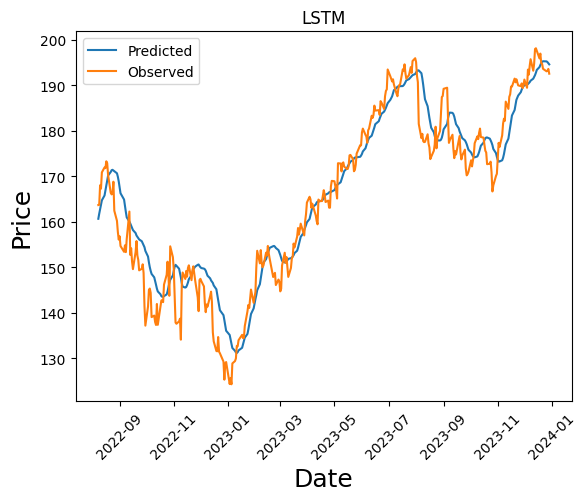

In [ ]:
company_stock.LSTM_model()

### RNN

Recurrent neural network (RNN)
11/11 [==============================] - 1s 13ms/step
RMSE: 19.200762735415637
MAPE: 0.08940961982514764


<ipython-input-28-ab32fcf984a7>:268: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = y_pred


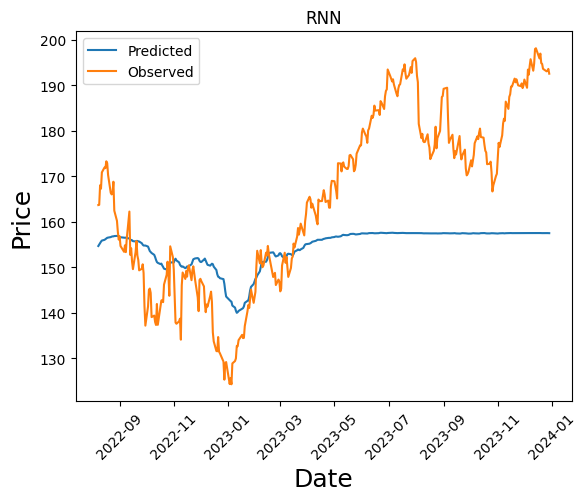

In [ ]:
company_stock.rnn_model()

### best model

In [ ]:
company_stock.best_model()

RMSE
[['ARIMA', 2.567319880920929], ['LSTM 1 epochs', 5.46069882162589], ['LSTM 2 epochs', 6.091654359234752], ['LSTM 2 epochs', 12.002121839906739], ['LSTM 2 epochs', 6.7913292463571855], ['RNN', 19.200762735415637]]
The best model is  ARIMA
Accuracy of  ARIMA is 2.567319880920929
MAPE
[['ARIMA', 0.01197033499466877], ['LSTM 1 epochs', 0.027253900607681084], ['LSTM 2 epochs', 0.03176992197409137], ['LSTM 2 epochs', 0.06338319880243395], ['LSTM 2 epochs', 0.035035705901412556], ['RNN', 0.08940961982514764]]
The best model is  ARIMA
Accuracy of  ARIMA is 0.01197033499466877


## 2022 - 2023

In [18]:
import yfinance as yf
import pandas as pd

ticker = yf.Ticker("AAPL")
aapl = ticker.history(start="2022-01-01", end="2023-12-31")

# convert index datetime to date
aapl.index = aapl.index.map(lambda x: x.date())

# Convert index column to date column
aapl.index = pd.to_datetime(aapl.index)
aapl.drop(['Dividends', 'Stock Splits'], axis=1, inplace=True)
aapl['Date'] = aapl.index
aapl.shape

(501, 6)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


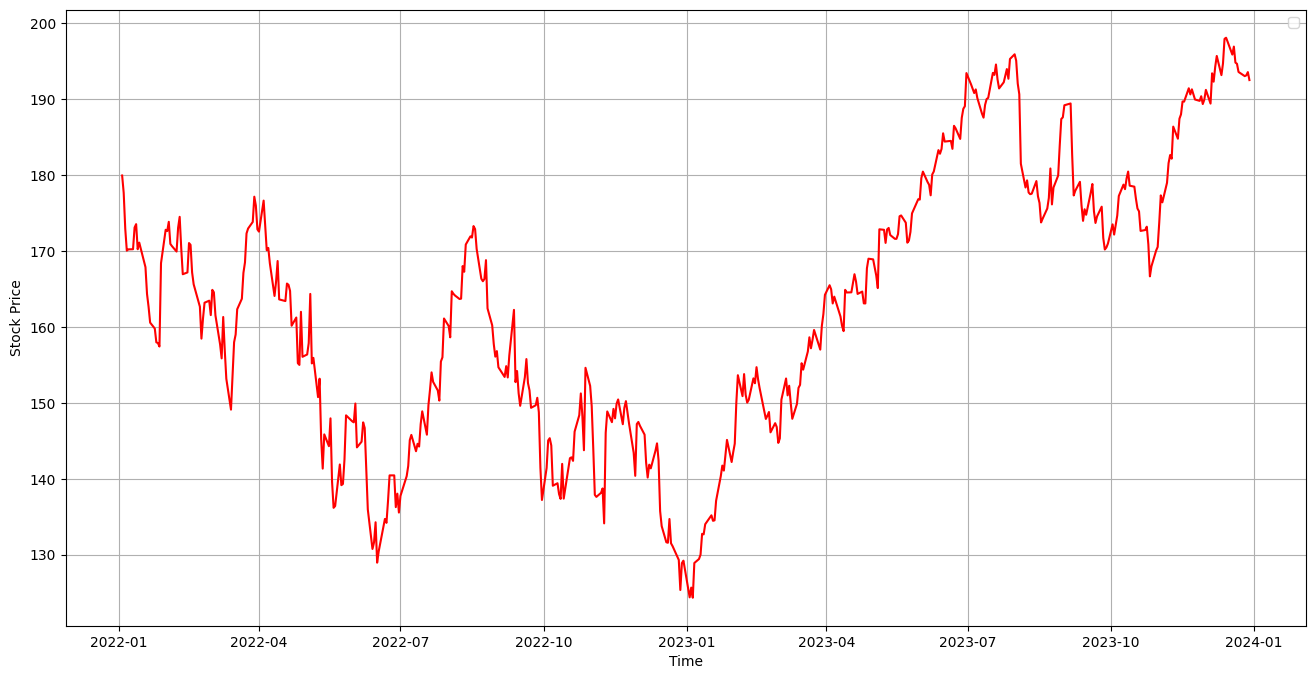

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16,8))
plt.plot(aapl.index, aapl['Close'], color = 'red')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)

plt.show()

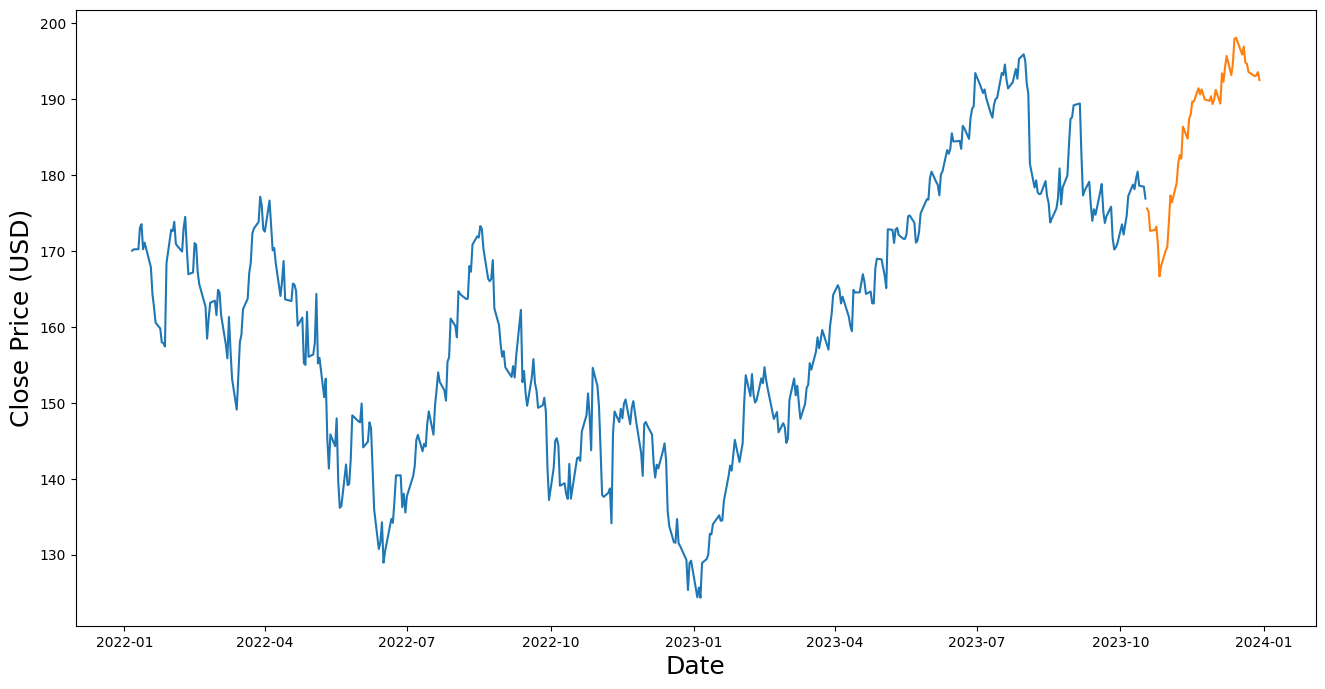

In [19]:
train_data, test_data = aapl[3:int(len(aapl)*0.9)], aapl[int(len(aapl)*0.9):]

plt.figure(figsize=(16,8))
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price (USD)', fontsize=18)
plt.plot(train_data['Close'])
plt.plot(test_data['Close'])
plt.show()

In [ ]:
company_stock = stock_predict_DL(aapl)


### ARIMA

Autoregressive Integrated Moving Average(ARIMA)
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2464.110, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2466.070, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2466.064, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2462.150, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2461.314, Time=0.37 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2462.765, Time=0.71 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2462.739, Time=0.59 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2466.268, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2466.301, Time=0.14 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2464.530, Time=0.85 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2459.350, Time=0.20 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=2464.103, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=2464.108, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=2460.804,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


RMSE: 2.0086015170413085
MAPE: 0.008751356749571787


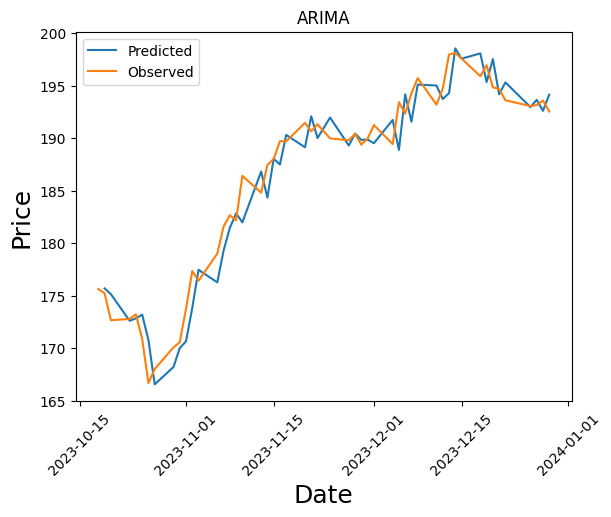

In [ ]:
company_stock.arima_model()

### LSTM

Long Short-Term Memory (LSTM)
Epoch 1/10
9/9 [==============================] - 5s 75ms/step - loss: 0.0615
Epoch 2/10
9/9 [==============================] - 1s 76ms/step - loss: 0.0248
Epoch 3/10
9/9 [==============================] - 1s 135ms/step - loss: 0.0176
Epoch 4/10
9/9 [==============================] - 2s 245ms/step - loss: 0.0131
Epoch 5/10
9/9 [==============================] - 1s 111ms/step - loss: 0.0124
Epoch 6/10
9/9 [==============================] - 1s 76ms/step - loss: 0.0131
Epoch 7/10
9/9 [==============================] - 1s 76ms/step - loss: 0.0114
Epoch 8/10
9/9 [==============================] - 1s 78ms/step - loss: 0.0117
Epoch 9/10
9/9 [==============================] - 1s 78ms/step - loss: 0.0116
Epoch 10/10
2/2 [==============================] - 1s 15ms/step
RMSE: 5.2918859687695
MAPE: 0.023821904299138507


<ipython-input-227-0d47a2b8781b>:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


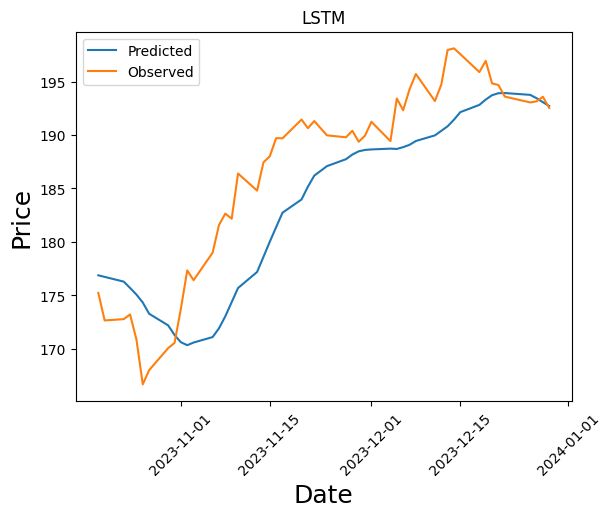

In [ ]:
company_stock.LSTM_model()

### RNN

Recurrent neural network (RNN)
Epoch 1/10
421/421 [==============================] - 3s 4ms/step - loss: 0.0104
Epoch 2/10
421/421 [==============================] - 2s 4ms/step - loss: 0.0052
Epoch 3/10
421/421 [==============================] - 2s 4ms/step - loss: 0.0042
Epoch 4/10
421/421 [==============================] - 2s 4ms/step - loss: 0.0035
Epoch 5/10
421/421 [==============================] - 3s 7ms/step - loss: 0.0032
Epoch 6/10
421/421 [==============================] - 2s 5ms/step - loss: 0.0029
Epoch 7/10
421/421 [==============================] - 2s 4ms/step - loss: 0.0027
Epoch 8/10
421/421 [==============================] - 2s 4ms/step - loss: 0.0026
Epoch 9/10
421/421 [==============================] - 2s 4ms/step - loss: 0.0024
Epoch 10/10
2/2 [==============================] - 0s 7ms/step
RMSE: 2.4801619839912536
MAPE: 0.010674020435027663


<ipython-input-227-0d47a2b8781b>:208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = y_pred


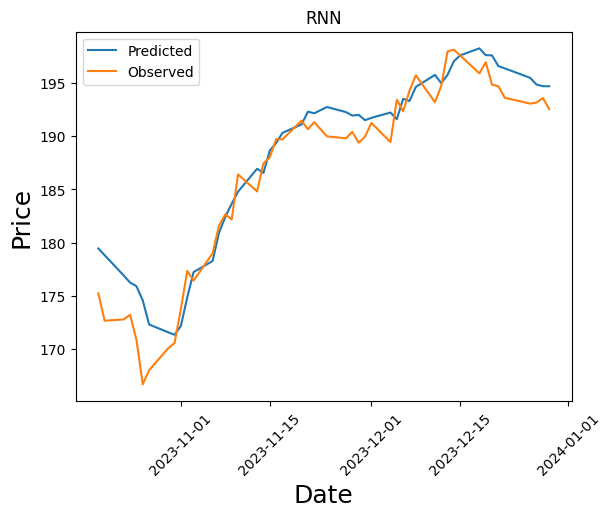

In [ ]:
company_stock.rnn_model()

### best model

In [ ]:
company_stock.best_model()

RMSE
[['ARIMA', 2.0086015170413085], ['LSTM', 7.428604854140279], ['RNN', 2.4801619839912536]]
The best model is  ARIMA
Accuracy of  ARIMA is 2.0086015170413085
MAPE
[['ARIMA', 0.008751356749571787], ['LSTM', 0.03471507002823142], ['RNN', 0.010674020435027663]]
The best model is  ARIMA
Accuracy of  ARIMA is 0.008751356749571787


# MSFT

## 2010 - 2023

In [20]:
import yfinance as yf
import pandas as pd

ticker = yf.Ticker("MSFT")
msft = ticker.history(start="2010-01-01", end="2023-12-31")

# convert index datetime to date
msft.index = msft.index.map(lambda x: x.date())

# Convert index column to date column
msft.index = pd.to_datetime(msft.index)
msft.drop(['Dividends', 'Stock Splits'], axis=1, inplace=True)
msft['Date'] = msft.index
msft.shape

(3522, 6)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


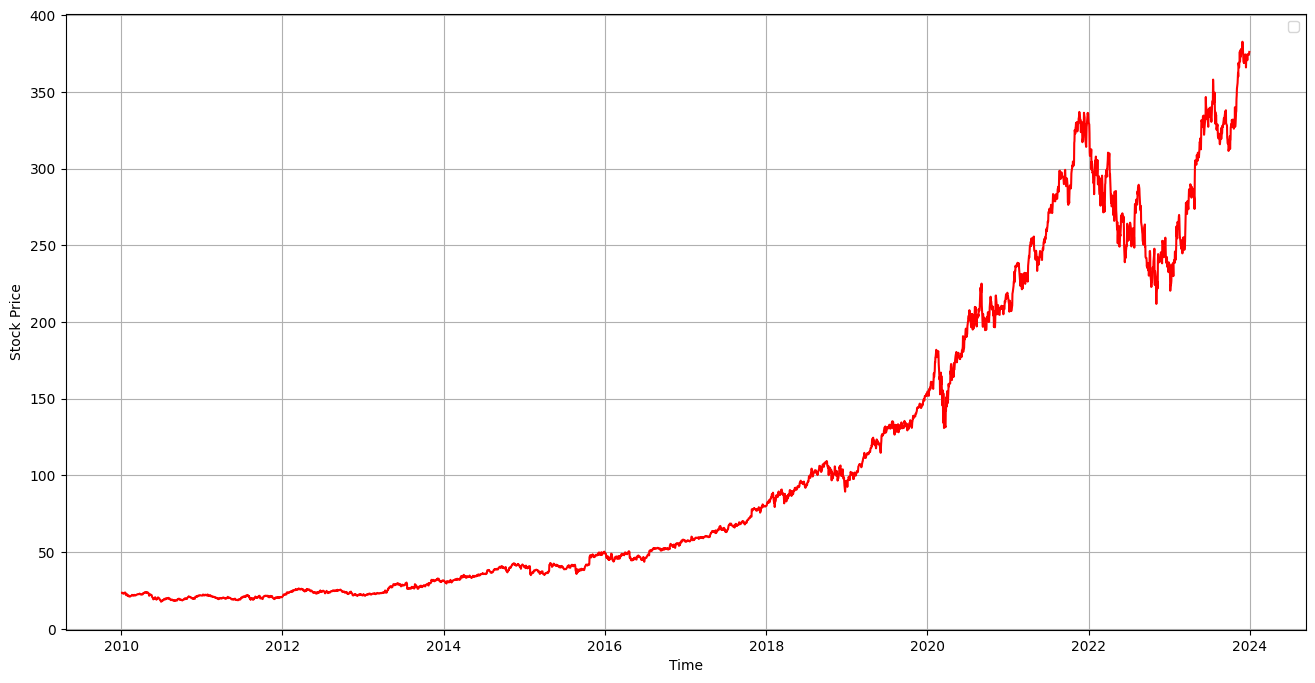

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16,8))
plt.plot(msft.index, msft['Close'], color = 'red')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)

plt.show()

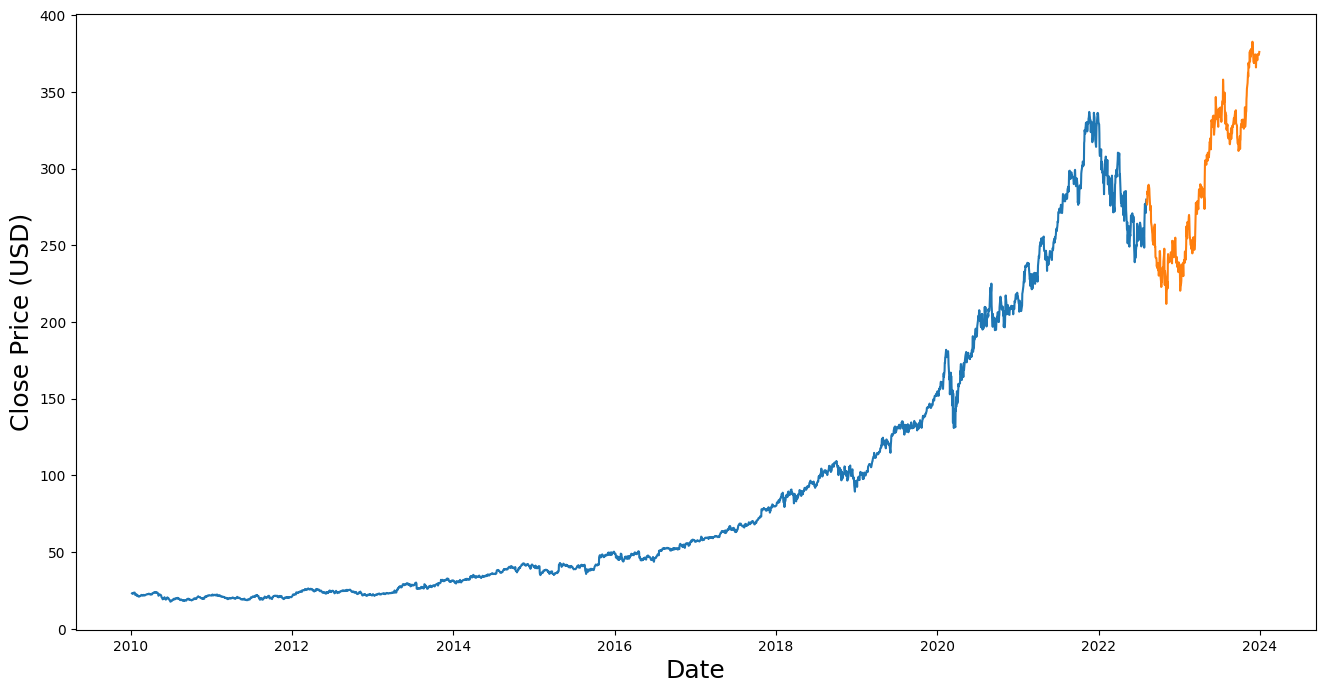

In [21]:
train_data, test_data = msft[3:int(len(msft)*0.9)], msft[int(len(msft)*0.9):]

plt.figure(figsize=(16,8))
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price (USD)', fontsize=18)
plt.plot(train_data['Close'])
plt.plot(test_data['Close'])
plt.show()

In [ ]:
company_stock = stock_predict_DL(msft)


### ARIMA

Autoregressive Integrated Moving Average(ARIMA)
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=16836.469, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=16801.223, Time=0.22 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=16798.873, Time=0.57 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=16839.525, Time=0.16 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=16797.489, Time=1.24 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=16799.354, Time=1.87 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=16799.380, Time=2.40 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=16798.392, Time=1.65 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=16799.656, Time=0.94 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=16801.448, Time=1.85 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=16802.481, Time=0.40 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 11.483 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


RMSE: 4.95817616822027
MAPE: 0.01337559120449731


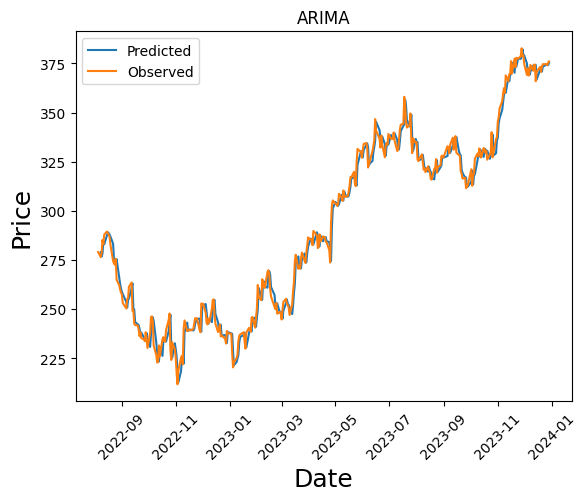

In [ ]:
company_stock.arima_model()

### LSTM

Long Short-Term Memory (LSTM)
Epoch 1/2
98/98 [==============================] - 15s 114ms/step - loss: 0.0053
Epoch 2/2
11/11 [==============================] - 1s 41ms/step
RMSE: 24.92031483673187
MAPE: 0.08132100904220524


<ipython-input-58-02790bc0840f>:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


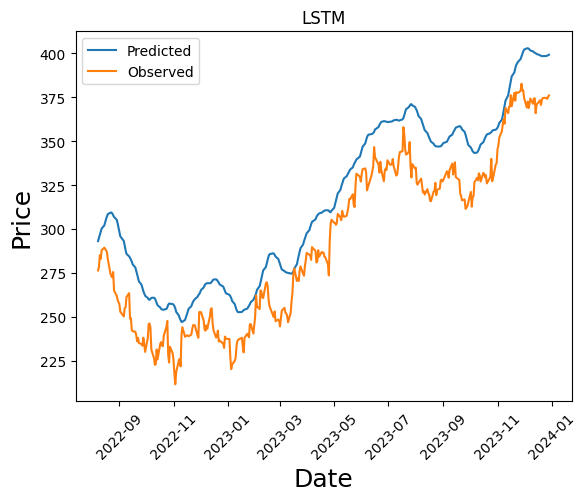

In [ ]:
company_stock.LSTM_model()

Long Short-Term Memory (LSTM)
11/11 [==============================] - 2s 65ms/step
RMSE: 10.621715447470827
MAPE: 0.031102087817302695


<ipython-input-58-02790bc0840f>:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


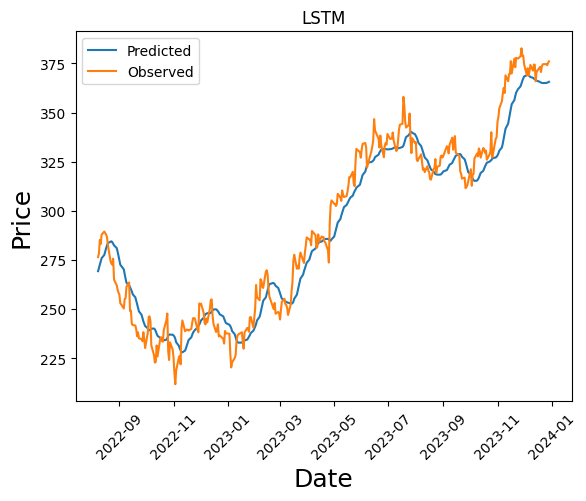

In [ ]:
company_stock.LSTM_model_2(1)

Long Short-Term Memory (LSTM)
Epoch 1/2
98/98 [==============================] - 15s 109ms/step - loss: 0.0051
Epoch 2/2
11/11 [==============================] - 2s 63ms/step
RMSE: 12.352093864214318
MAPE: 0.035511113987040564


<ipython-input-58-02790bc0840f>:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


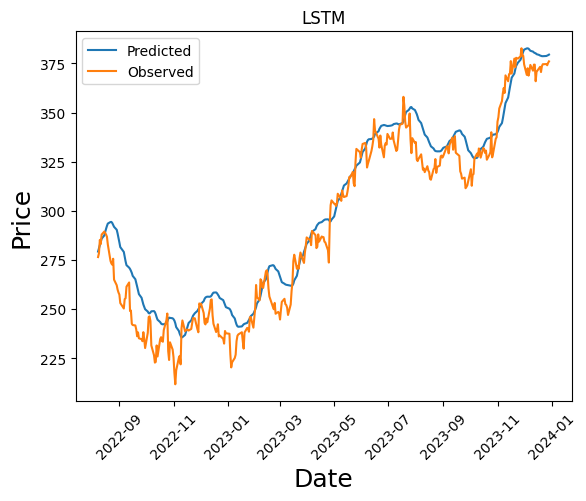

In [ ]:
company_stock.LSTM_model_2(2)

Long Short-Term Memory (LSTM)
Epoch 1/3
98/98 [==============================] - 14s 107ms/step - loss: 0.0046
Epoch 2/3
98/98 [==============================] - 10s 99ms/step - loss: 0.0022
Epoch 3/3
11/11 [==============================] - 1s 33ms/step
RMSE: 11.68779104431778
MAPE: 0.033457036470377136


<ipython-input-58-02790bc0840f>:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


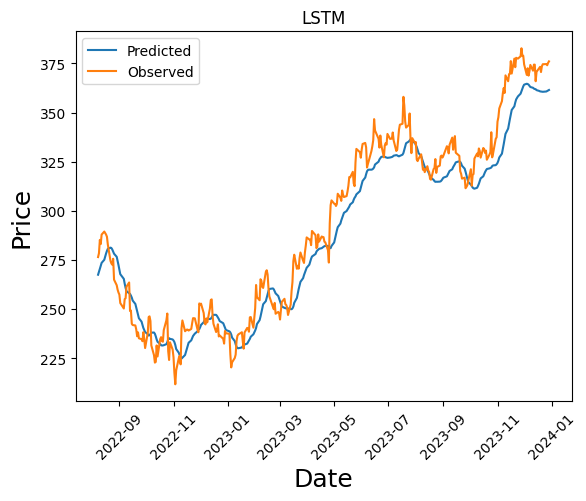

In [ ]:
company_stock.LSTM_model_2(3)

### RNN

Recurrent neural network (RNN)
11/11 [==============================] - 1s 12ms/step
RMSE: 99.42042648789118
MAPE: 0.29061659249861754


<ipython-input-58-02790bc0840f>:268: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = y_pred


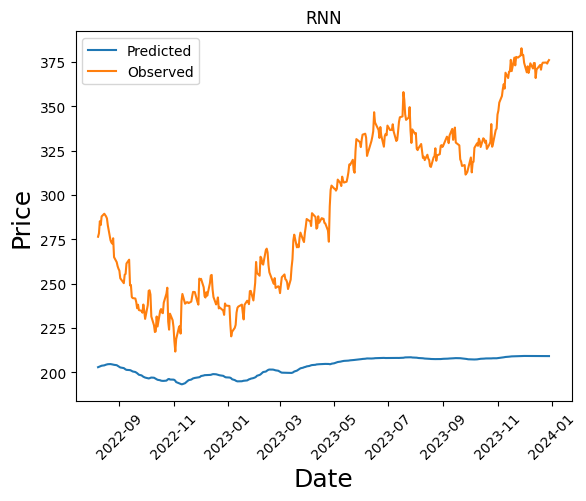

In [ ]:
company_stock.rnn_model()

### best model

In [ ]:
company_stock.best_model()

RMSE
[['ARIMA', 4.95817616822027], ['LSTM 1 epochs', 24.92031483673187], ['LSTM 1 epochs', 10.621715447470827], ['LSTM 2 epochs', 12.352093864214318], ['LSTM 3 epochs', 11.68779104431778], ['RNN', 99.42042648789118]]
The best model is  ARIMA
Accuracy of  ARIMA is 4.95817616822027
MAPE
[['ARIMA', 0.01337559120449731], ['LSTM 1 epochs', 0.08132100904220524], ['LSTM 1 epochs', 0.031102087817302695], ['LSTM 2 epochs', 0.035511113987040564], ['LSTM 3 epochs', 0.033457036470377136], ['RNN', 0.29061659249861754]]
The best model is  ARIMA
Accuracy of  ARIMA is 0.01337559120449731


## 2022 - 2023

In [22]:
import yfinance as yf
import pandas as pd

ticker = yf.Ticker("MSFT")
msft = ticker.history(start="2022-01-01", end="2023-12-31")

# convert index datetime to date
msft.index = msft.index.map(lambda x: x.date())

# Convert index column to date column
msft.index = pd.to_datetime(msft.index)
msft.drop(['Dividends', 'Stock Splits'], axis=1, inplace=True)
msft['Date'] = msft.index
msft.shape

(501, 6)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


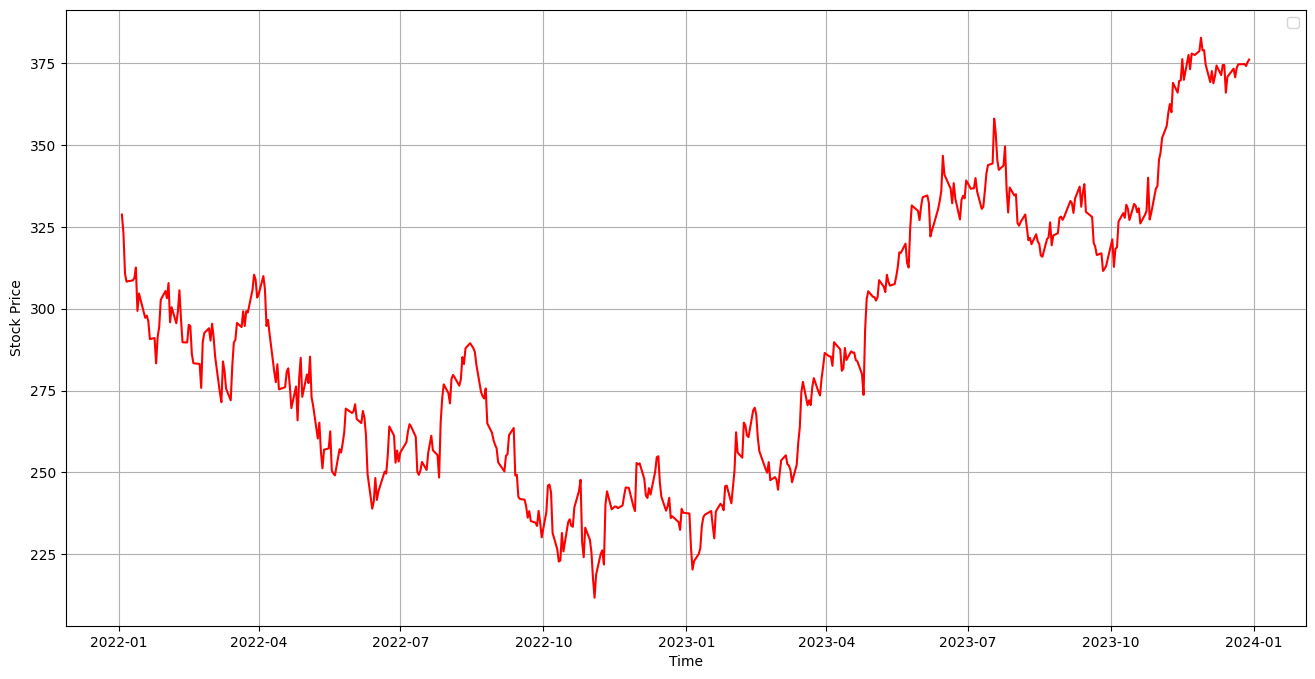

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16,8))
plt.plot(msft.index, msft['Close'], color = 'red')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)

plt.show()

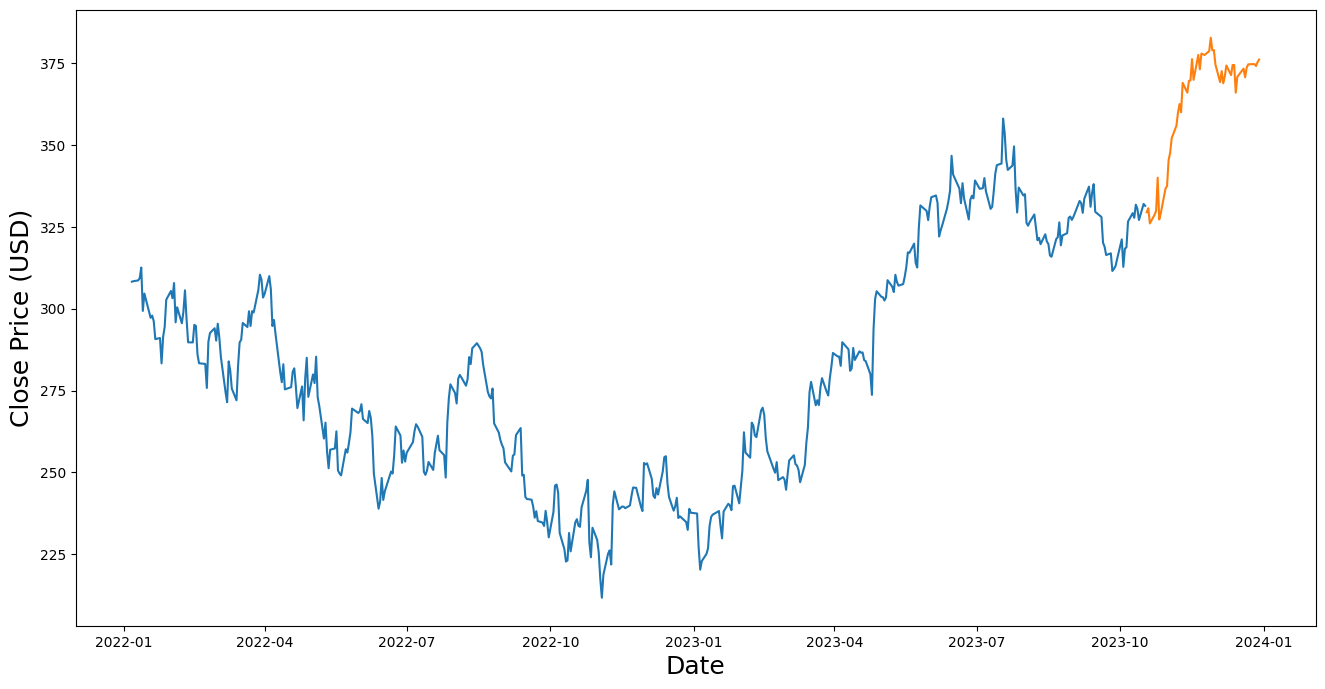

In [23]:
train_data, test_data = msft[3:int(len(msft)*0.9)], msft[int(len(msft)*0.9):]

plt.figure(figsize=(16,8))
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price (USD)', fontsize=18)
plt.plot(train_data['Close'])
plt.plot(test_data['Close'])
plt.show()

In [ ]:
company_stock = stock_predict_DL(msft)


### ARIMA

Autoregressive Integrated Moving Average(ARIMA)
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3095.230, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3096.800, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3096.705, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3093.388, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3096.178, Time=0.71 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.005 seconds
RMSE: 4.500766502984545
MAPE: 0.009863336098612339


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


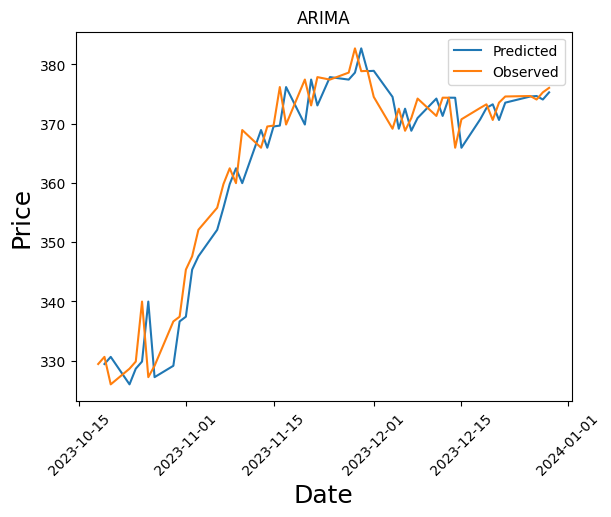

In [ ]:
company_stock.arima_model()

### LSTM

Long Short-Term Memory (LSTM)
Epoch 1/2
13/13 [==============================] - 5s 95ms/step - loss: 0.0516
Epoch 2/2
2/2 [==============================] - 1s 20ms/step
RMSE: 17.864610364174005
MAPE: 0.04380147134372017


<ipython-input-58-02790bc0840f>:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


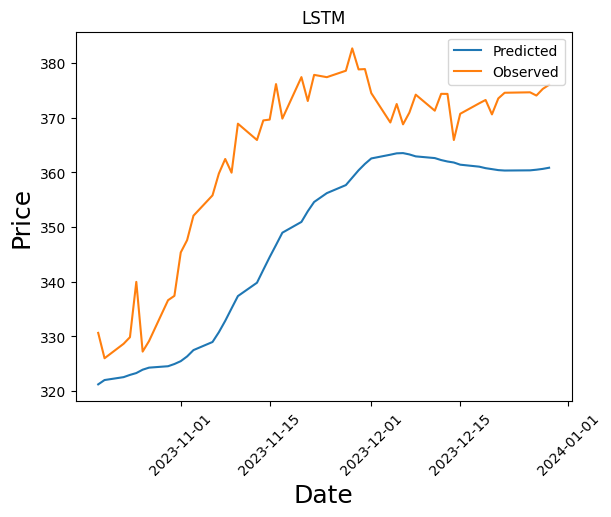

In [ ]:
company_stock.LSTM_model()

### RNN

Recurrent neural network (RNN)
2/2 [==============================] - 0s 14ms/step
RMSE: 56.40102506639573
MAPE: 0.1484826725292435


<ipython-input-58-02790bc0840f>:268: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = y_pred


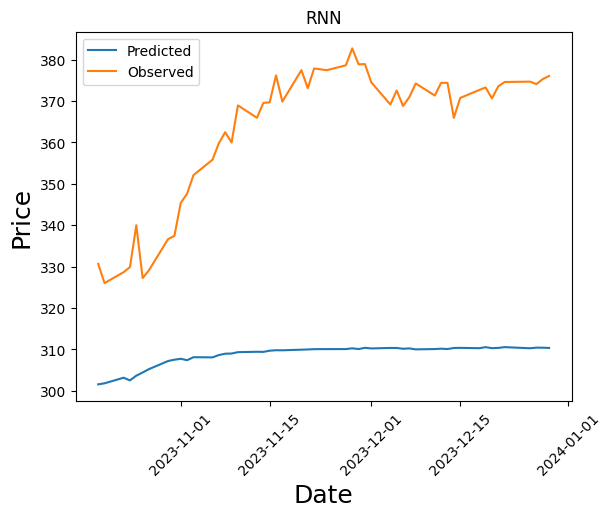

In [ ]:
company_stock.rnn_model()

### best model

In [ ]:
company_stock.best_model()

RMSE
[['ARIMA', 4.500766502984545], ['LSTM 1 epochs', 17.864610364174005], ['RNN', 56.40102506639573]]
The best model is  ARIMA
Accuracy of  ARIMA is 4.500766502984545
MAPE
[['ARIMA', 0.009863336098612339], ['LSTM 1 epochs', 0.04380147134372017], ['RNN', 0.1484826725292435]]
The best model is  ARIMA
Accuracy of  ARIMA is 0.009863336098612339


# TSLA

## 2014 - 2023

In [24]:
import yfinance as yf
import pandas as pd

ticker = yf.Ticker("TSLA")
tsla = ticker.history(start="2014-01-01", end="2023-12-31")

# convert index datetime to date
tsla.index = tsla.index.map(lambda x: x.date())

# Convert index column to date column
tsla.index = pd.to_datetime(tsla.index)
tsla.drop(['Dividends', 'Stock Splits'], axis=1, inplace=True)
tsla['Date'] = tsla.index
tsla.shape

(2516, 6)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


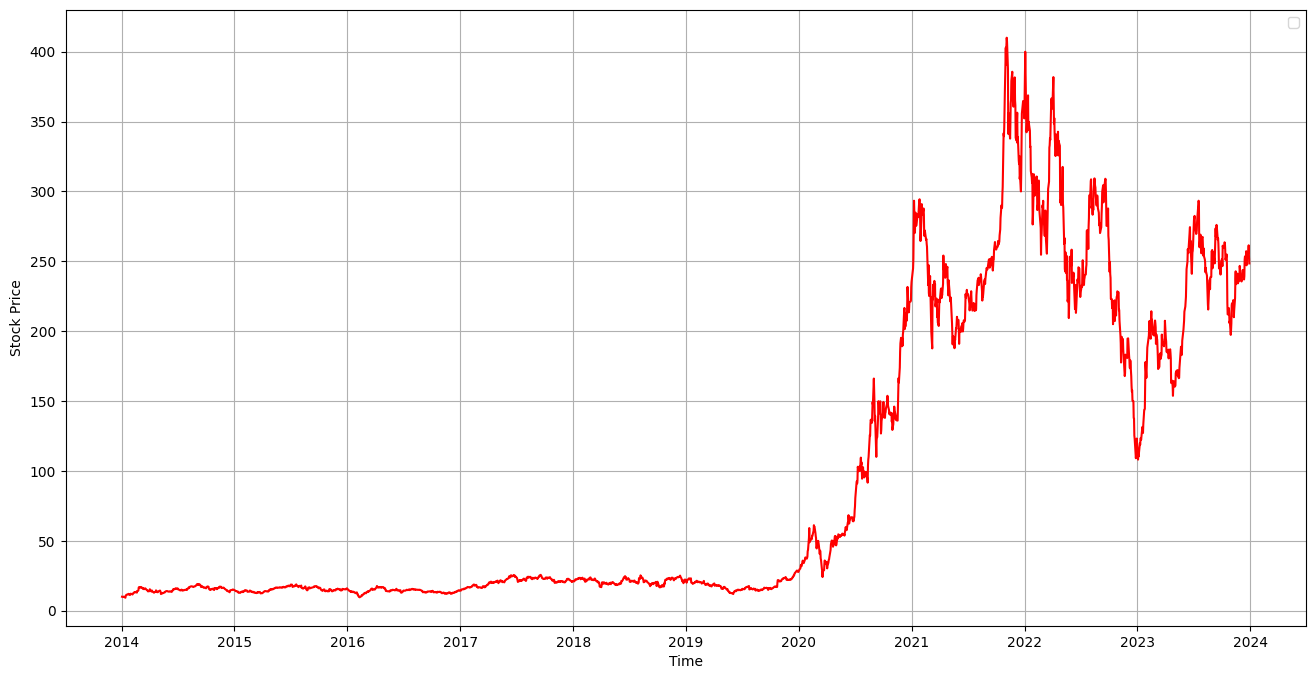

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16,8))
plt.plot(tsla.index, tsla['Close'], color = 'red')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)

plt.show()

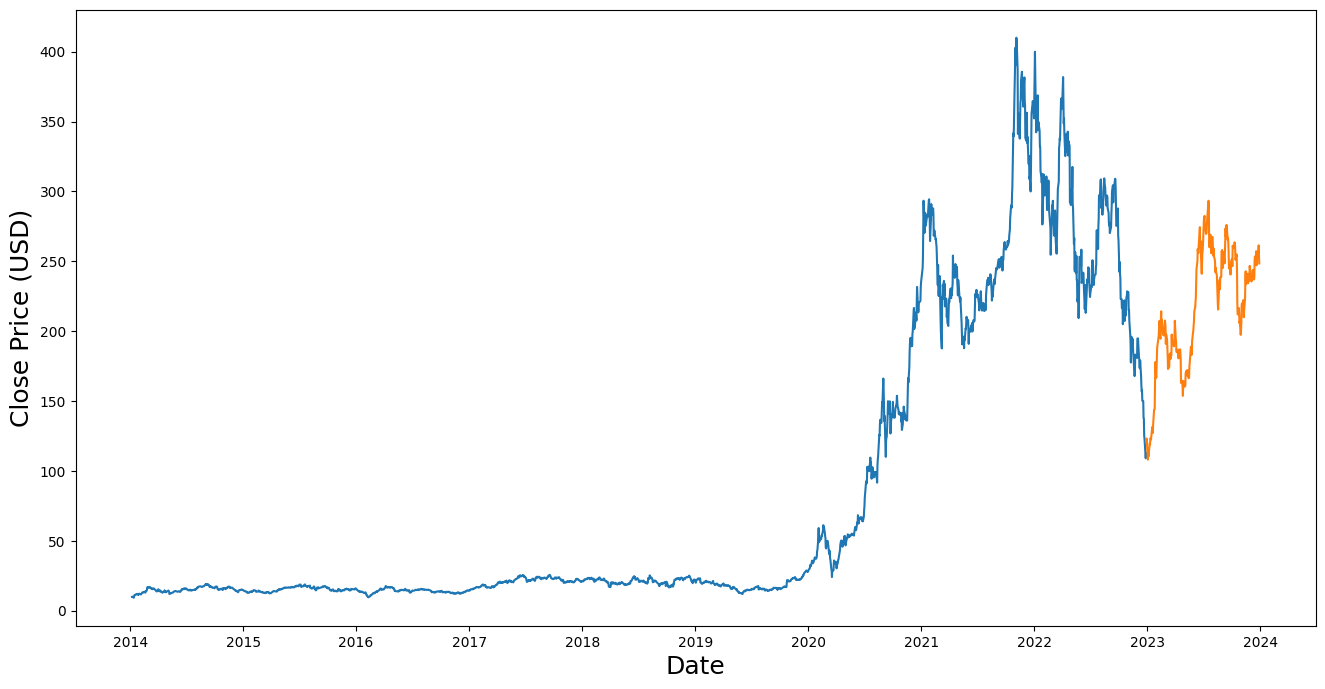

In [25]:
train_data, test_data = tsla[3:int(len(tsla)*0.9)], tsla[int(len(tsla)*0.9):]

plt.figure(figsize=(16,8))
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price (USD)', fontsize=18)
plt.plot(train_data['Close'])
plt.plot(test_data['Close'])
plt.show()

In [ ]:
tsla

,Open,High,Low,Close,Volume,Date
Date,,,,,,
2014-01-02,9.986667,10.165333,9.770000,10.006667,92826000,2014-01-02
2014-01-03,10.000000,10.146000,9.906667,9.970667,70425000,2014-01-03
2014-01-06,10.000000,10.026667,9.682667,9.800000,80416500,2014-01-06
2014-01-07,9.841333,10.026667,9.683333,9.957333,75511500,2014-01-07
2014-01-08,9.923333,10.246667,9.917333,10.085333,92448000,2014-01-08
...,...,...,...,...,...,...
2023-12-22,256.760010,258.220001,251.369995,252.539993,93249800,2023-12-22
2023-12-26,254.490005,257.970001,252.910004,256.609985,86892400,2023-12-26
2023-12-27,258.350006,263.339996,257.519989,261.440002,106494400,2023-12-27


In [ ]:
company_stock = stock_predict_DL(tsla)


### ARIMA

Autoregressive Integrated Moving Average(ARIMA)
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=15640.867, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=15640.547, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=15640.610, Time=0.38 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=15639.637, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=15640.722, Time=2.05 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 2.808 seconds
RMSE: 7.1124416084077415
MAPE: 0.02567074391818049


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


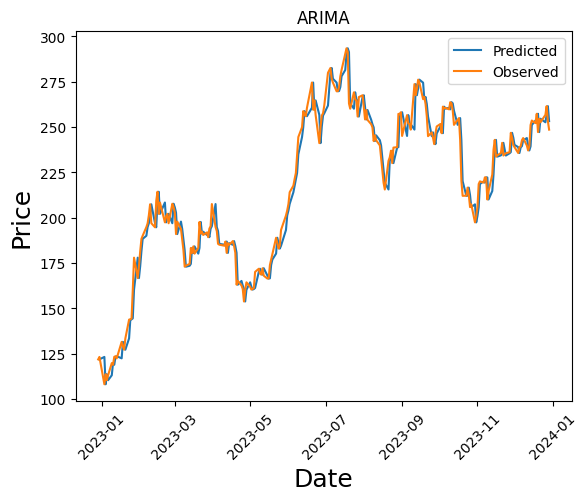

In [ ]:
company_stock.arima_model()

### LSTM

Long Short-Term Memory (LSTM)
Epoch 1/2
69/69 [==============================] - 11s 96ms/step - loss: 0.0067
Epoch 2/2
8/8 [==============================] - 2s 63ms/step
RMSE: 24.943493756578153
MAPE: 0.1014670707366399


<ipython-input-58-02790bc0840f>:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


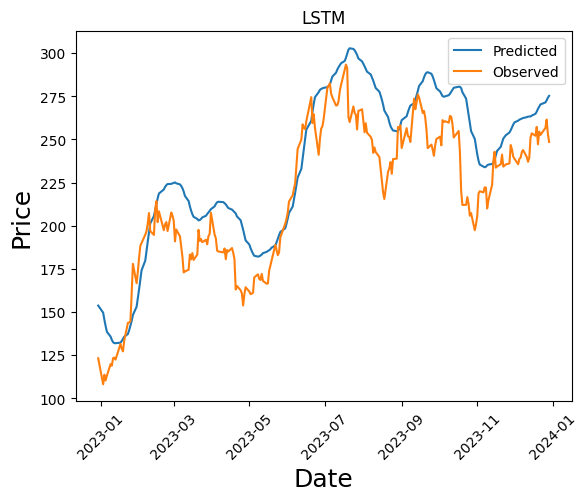

In [ ]:
company_stock.LSTM_model()

### RNN

Recurrent neural network (RNN)
8/8 [==============================] - 1s 10ms/step
RMSE: 18.629472163028087
MAPE: 0.07345415221196877


<ipython-input-58-02790bc0840f>:268: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = y_pred


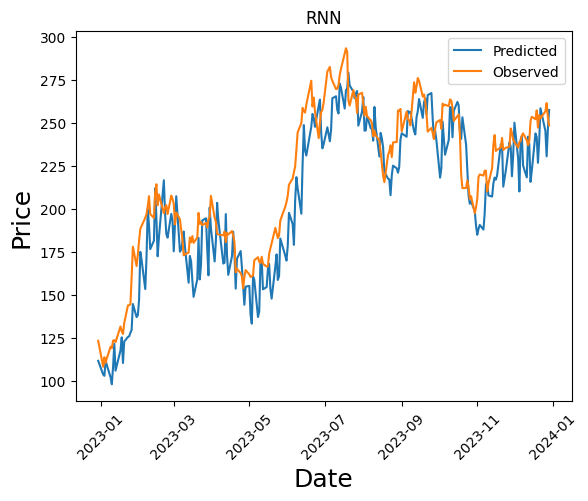

In [ ]:
company_stock.rnn_model()

### best model

In [ ]:
company_stock.best_model()

RMSE
[['ARIMA', 7.1124416084077415], ['LSTM 1 epochs', 24.943493756578153], ['RNN', 18.629472163028087]]
The best model is  ARIMA
Accuracy of  ARIMA is 7.1124416084077415
MAPE
[['ARIMA', 0.02567074391818049], ['LSTM 1 epochs', 0.1014670707366399], ['RNN', 0.07345415221196877]]
The best model is  ARIMA
Accuracy of  ARIMA is 0.02567074391818049


## 2022 - 2023

In [26]:
import yfinance as yf
import pandas as pd

ticker = yf.Ticker("TSLA")
tsla = ticker.history(start="2022-01-01", end="2023-12-31")

# convert index datetime to date
tsla.index = tsla.index.map(lambda x: x.date())

# Convert index column to date column
tsla.index = pd.to_datetime(tsla.index)
tsla.drop(['Dividends', 'Stock Splits'], axis=1, inplace=True)
tsla['Date'] = tsla.index
tsla.shape

(501, 6)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


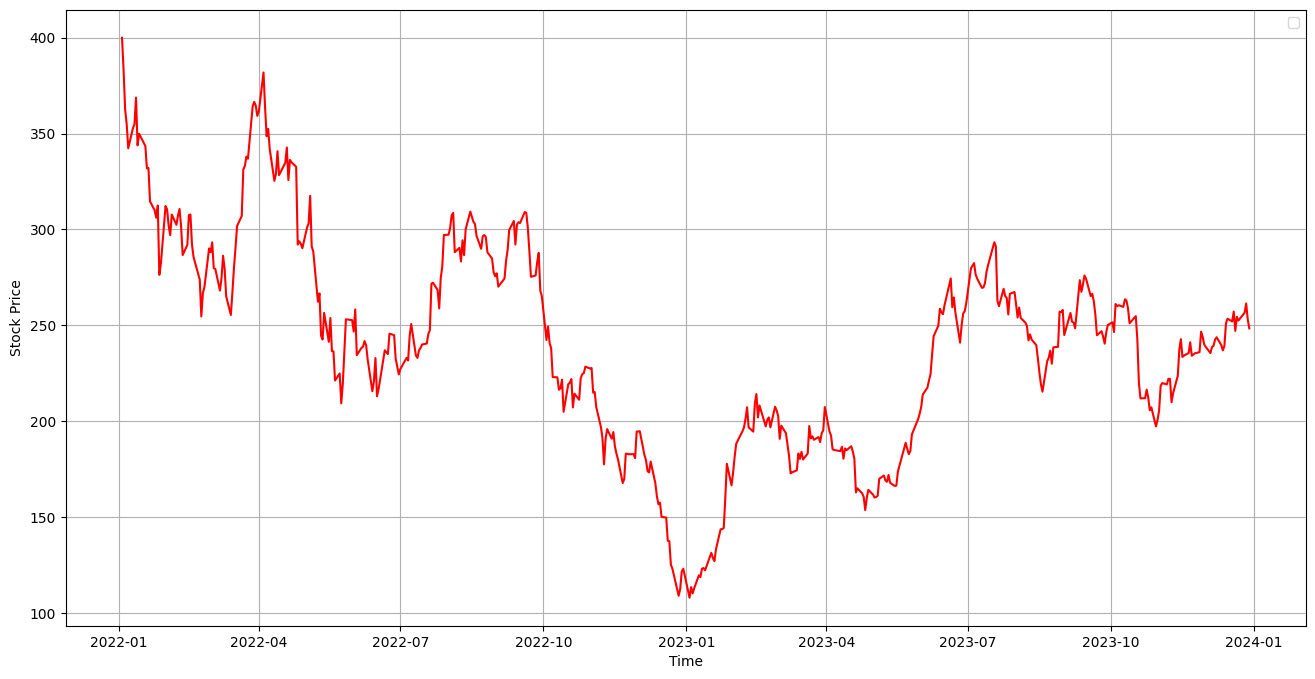

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16,8))
plt.plot(tsla.index, tsla['Close'], color = 'red')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)

plt.show()

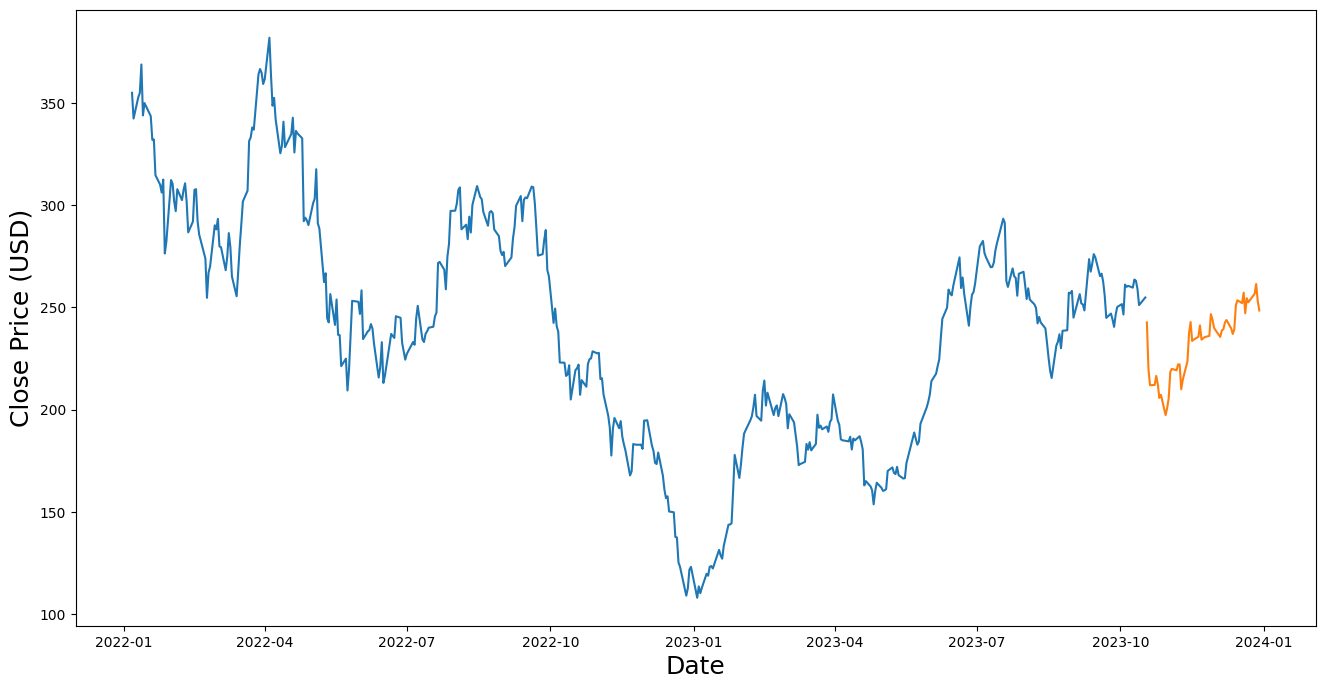

In [27]:
train_data, test_data = tsla[3:int(len(tsla)*0.9)], tsla[int(len(tsla)*0.9):]

plt.figure(figsize=(16,8))
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price (USD)', fontsize=18)
plt.plot(train_data['Close'])
plt.plot(test_data['Close'])
plt.show()

In [ ]:
tsla

,Open,High,Low,Close,Volume,Date
Date,,,,,,
2022-01-03,382.583344,400.356659,378.679993,399.926666,103931400,2022-01-03
2022-01-04,396.516663,402.666656,374.350006,383.196655,100248300,2022-01-04
2022-01-05,382.216675,390.113342,360.336670,362.706665,80119800,2022-01-05
2022-01-06,359.000000,362.666656,340.166656,354.899994,90336600,2022-01-06
2022-01-07,360.123322,360.309998,336.666656,342.320007,84164700,2022-01-07
...,...,...,...,...,...,...
2023-12-22,256.760010,258.220001,251.369995,252.539993,93249800,2023-12-22
2023-12-26,254.490005,257.970001,252.910004,256.609985,86892400,2023-12-26
2023-12-27,258.350006,263.339996,257.519989,261.440002,106494400,2023-12-27


In [ ]:
company_stock = stock_predict_DL(tsla)


### ARIMA

Autoregressive Integrated Moving Average(ARIMA)
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3634.451, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3636.051, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3636.077, Time=0.43 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3633.001, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3635.611, Time=0.77 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.466 seconds
RMSE: 6.885704663062172
MAPE: 0.022761922599664104


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


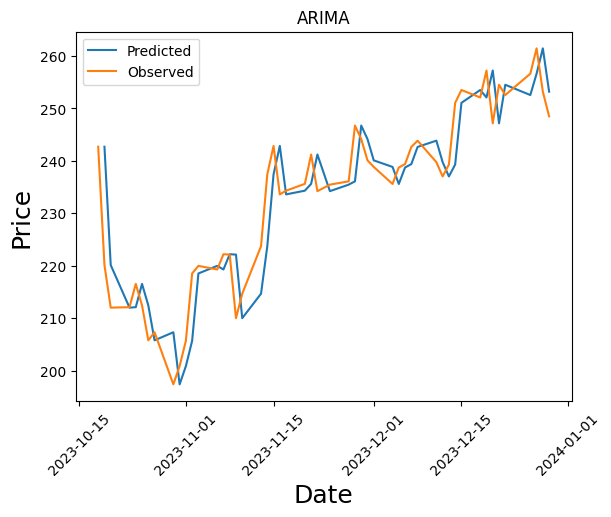

In [ ]:
company_stock.arima_model()

### LSTM

Long Short-Term Memory (LSTM)
Epoch 1/2
13/13 [==============================] - 5s 90ms/step - loss: 0.0573
Epoch 2/2
2/2 [==============================] - 1s 22ms/step
RMSE: 16.425729400700632
MAPE: 0.06357902818752464


<ipython-input-58-02790bc0840f>:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


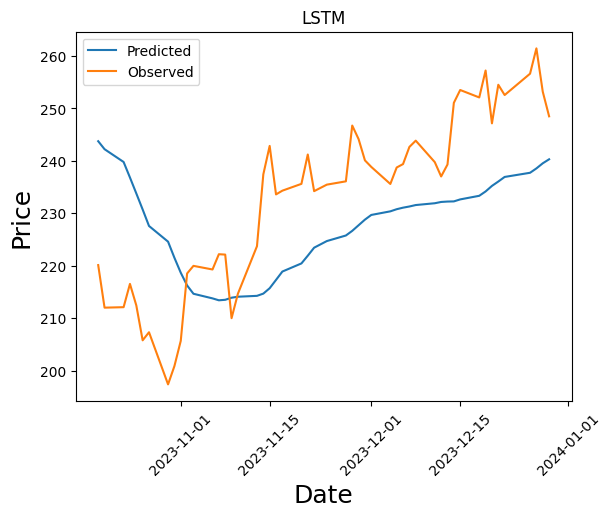

In [ ]:
company_stock.LSTM_model()

### RNN

Recurrent neural network (RNN)
2/2 [==============================] - 0s 14ms/step
RMSE: 16.761353414472836
MAPE: 0.06138932910418322


<ipython-input-58-02790bc0840f>:268: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = y_pred


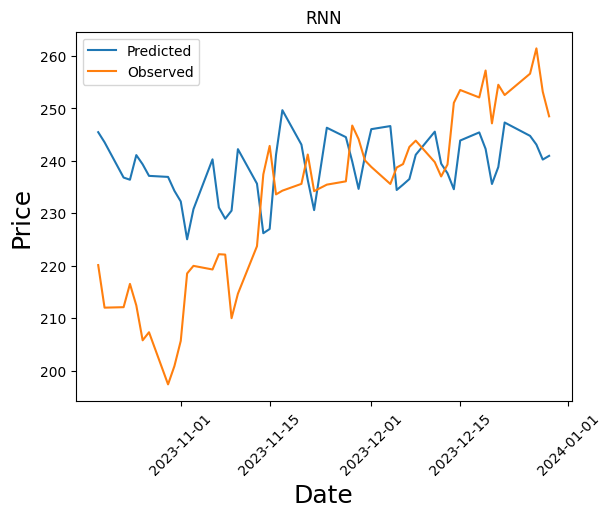

In [ ]:
company_stock.rnn_model()

### best model

In [ ]:
company_stock.best_model()

RMSE
[['ARIMA', 6.885704663062172], ['LSTM 1 epochs', 16.425729400700632], ['RNN', 16.761353414472836]]
The best model is  ARIMA
Accuracy of  ARIMA is 6.885704663062172
MAPE
[['ARIMA', 0.022761922599664104], ['LSTM 1 epochs', 0.06357902818752464], ['RNN', 0.06138932910418322]]
The best model is  ARIMA
Accuracy of  ARIMA is 0.022761922599664104
